In [1]:
import draw
from params import *
from utils import *
import torch
import numpy as np

In [2]:
hand = draw.Hand("/home/bobby/final_proj/saved_models/Simple-HWTF-Better-Loss-Small-Writer-Specific")

/home/bobby/final_proj/saved_models/Simple-HWTF-Better-Loss-Small-Writer-Specific : Model loaded Successfully


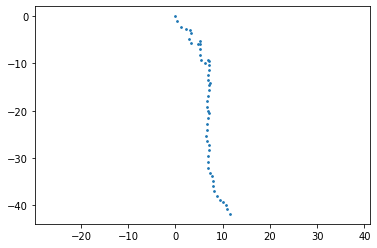

In [8]:
batch = {}
batch['c'] = torch.tensor([alpha_to_num[c] for c in  r""""d"""]).unsqueeze(0).to(DEVICE)
batch['c_len'] = torch.tensor([len(batch['c'])]).unsqueeze(0).to(DEVICE)

batch_seq_char = batch['c']
batch_seq_char_len = batch['c_len']

output = predict_no_guidance(hand.model.to(DEVICE), batch)
sequence_to_jpg(output, None)

In [12]:
for name, val in hand.model.named_parameters():
    print(name, val)

src_embed.0.weight Parameter containing:
tensor([[-5.0322e-01, -2.6048e-01,  1.0422e+00,  5.4118e-01, -8.1929e-01,
          6.7467e-01,  2.6111e-01,  1.2818e+00],
        [-1.5490e-01, -6.3024e-01, -4.3912e-01, -6.2807e-02, -4.2288e-01,
          1.8796e-01,  1.1198e+00,  8.5921e-01],
        [ 1.0009e+00, -6.6988e-01,  1.1764e-01, -1.2317e-01, -2.6964e+00,
         -7.2966e-01,  3.5861e-01, -1.3617e+00],
        [-1.5680e+00,  5.9517e-01, -7.6425e-01, -8.6856e-01,  6.5248e-01,
          3.0019e+00,  3.4587e-01, -5.7145e-01],
        [ 2.8827e-01, -7.6291e-02,  6.8351e-02, -4.9452e-01,  5.9588e-01,
         -4.8415e-01, -4.9395e-01,  1.4478e-01],
        [ 5.0873e-01, -6.8575e-01, -3.5091e-02, -9.0031e-01, -7.5728e-01,
          6.1045e-01,  1.1376e+00,  2.9698e-01],
        [-1.4027e+00, -5.8262e-01, -7.4830e-01,  8.2008e-01, -6.2746e-01,
         -4.5905e-01, -8.9025e-01,  8.1181e-01],
        [-6.4314e-01,  3.5769e-02, -4.5531e-01,  5.0291e-01,  7.4855e-01,
          2.8968e-01, -1

In [3]:
data_cols = ['x', 'x_len', 'c', 'c_len', 'w_id']
data_dir = "data/processed"
data = []

for col in data_cols:
    data.append(
        torch.from_numpy(
            np.load(os.path.join(data_dir, '{}.npy'.format(col)))
        ).to(DEVICE)
    )
data[2] = data[2].type(torch.int) # int8 is not compatible with Pytorch
print(data[0].shape)

train_batch = {}

for col_idx, col in enumerate(data_cols):
    train_batch[col] = data[col_idx][[0], ...]


torch.Size([11615, 1200, 3])


In [13]:
output

tensor([[[ 0.0000,  0.0000,  1.0000],
         [ 0.1152, -0.2449,  0.0000],
         [-0.5603, -0.0570,  0.0000],
         ...,
         [15.9019, 17.7053,  0.0000],
         [15.9940, 17.6861,  0.0000],
         [16.0309, 17.1974,  0.0000]]], device='cuda:0', grad_fn=<CopySlices>)

In [6]:
filename = "hello.svg"
hand._draw(strokes=output.cpu().detach().numpy(), lines=["hello"], filename=filename)

torch.Size([11615, 1200, 3])


In [6]:
train_batch['x']

tensor([[[ 0.0000,  0.0000,  1.0000],
         [ 0.1970, -0.2660,  0.0000],
         [ 0.1404, -0.1231,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]]], device='cuda:0')